## Setup Code

Before we start lets install some dependencies

In [1]:
# the bottom is only necessary to run on Colab or Kaggle Notebooks. It enables rendering of classical gym environments
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# the below is necessary since kaggle auto imports this library and it's too high of a version for gym
!pip install --upgrade "importlib_metadata<5.0"
# below is necessary since kaggle notebooks run on python 3.7
!pip install pyglet==1.4.11

  Attempting uninstall: importlib_metadata
    Found existing installation: importlib-metadata 6.0.0
    Uninstalling importlib-metadata-6.0.0:
      Successfully uninstalled importlib-metadata-6.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flake8 5.0.4 requires importlib-metadata<4.3,>=1.1.0; python_version < "3.8", but you have importlib-metadata 4.13.0 which is incompatible.
cmudict 1.0.13 requires importlib-metadata<6.0.0,>=5.1.0, but you have importlib-metadata 4.13.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.3 MB/s eta 0:00:0000:0100:010m


In [2]:
!pip install gym==0.21
!pip install gym[classic_control] # install classic control envs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.5 MB/s eta 0:00:0000:0100:010m
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=71d76ad61fb1379b9c246eb7e5dcab0c86bf716ce3f0be1ecb6d1fd894f281a9
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2


In [5]:
import importlib
import importlib_metadata
# kaggle has 6.0.0 installed but we need version <5.0
importlib.reload(importlib_metadata)

<module 'importlib_metadata' from '/opt/conda/lib/python3.7/site-packages/importlib_metadata/__init__.py'>

# Introduction to Reinforcement Learning 🤖

Looking to try out RL for the Lux AI competition on Kaggle? If you haven't tried RL before, this tutorial is a perfect quick start into how RL generally works, and how to program a basic agent. This is part 1 of a 3 part series on training RL agents leading up to a succesful RL agent submittable to the Lux AI competition. Part 1 will cover the basics of RL, how gym environments work, and how to train an agent and scale up training.

Let's dig in, welcome to the world of reinforcement learning!

In AI, RL is a framework of **learning via interaction**, often trying to **maximize the reinforcing reward**. Humans and animals alike sort of naturally follow the paradigm in learning behaviors. We reward a dog for doing a trick via a positive reward signal by giving it a treat. We penalize a dog for peeing on the floor by giving a negative reward signal (saying no!) or giving no reward. For a fun video of reinforcement learning you can watch this chicken below immediately learn to peck a particular colored dot via reinforcing it's actions with food.

In [6]:
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/spfpBrBjntg", 640, 480,)

RL has seen a massive growth in applications in recent years thanks to the rise of deep learning resulting in Deep Reinforcement Learning. Deep learning has enabled models trained via RL to solve far more complex tasks, including [mining diamonds in Minecraft](https://danijar.com/project/dreamerv3/), [managing a nuclear fusion reactor](https://www.deepmind.com/blog/accelerating-fusion-science-through-learned-plasma-control), or [controlling a legged robot](https://manipulation-locomotion.github.io/).


This tutorial will cover the practical basics of RL and how to program a simple deep RL agent. For those more interested in some of the history, math, and more advanced details of RL I highly recommend reading the following seminal book on RL by Richard S. Sutton and Andrew G. Barto: http://www.incompleteideas.net/book/RLbook2020.pdf

## 1 The Environment Loop

The core component of RL is the environment loop. It's what enables an agent in an environment to repeatedly interact and improve itself.

We discretize time in an environment into individual **time steps** labeled as `t` below. At each time step, the agent uses the current environment observation (also known as state) $S_t$ to produce an action $A_t$ and executes that action in the environment. The environment updates in response to the action and gives the agent a new observation $S_{t+1}$ as well as a reward signal $R_{t+1}$ telling the agent how well it is doing. Eventually the environment will tell the agent it is completed and this completes one full episode.

![](https://github.com/Lux-AI-Challenge/Lux-Design-S2/blob/main/kits/rl/tutorials/assets/rl_loop.jpg?raw=1)

These days, in deep RL the agent is typically a deep neural network that takes an observation as input and produces an action as output.

While the agent is continously interacting, it will also periodically update its neural network via an optimization algorithm with a few objectives. Training in RL requires balancing exploration and exploitation. While the overall goal of the agent is to exploit and to **maximize return** (the sum of rewards in an episode), you can easily learn suboptimal behaviors if you don't explore sufficiently in an environment to find better strategies. This explore vs exploitation problem is a foundational problem in RL that is still researched to this day.

For a deep dive into the math and algorithms the [Spinning Up project](https://spinningup.openai.com/en/latest/) provides a great tutorial on some of the modern deep RL algorithms.


### 1.1 Environment Loop Code

Let's get programming! The [Gym](https://github.com/openai/gym) package has now become the de-facto standard of the environment API and we will write code to show how to create an environment and interact with it here

*Note: Recently the [Farama Foundation](https://farama.org/) which now manages the Gym package (now called [Gymnasium](https://www.gymlibrary.dev/)) has made several changes to the Gym API which is incompatible with most environments and RL libraries at the moment. This tutorial will be using the original API.*

Let's first import a few packages and do some setup for a notebook

In [7]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# pyvirtusldisplay is only needed if running on a Colab or Kaggle notebook
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

To create an environment with `gym`, any environemnt that is registered with gym can be created with `gym.make(env_id)`. To start looking at what it looks like you have to first call `env.reset()` to start from a clean state. It's highly recommended to also use `env.seed` to seed environment to ensure reproducible resultss.

`env.render()` will render the environment with a display window (if possible). For users without access to GUI (e.g. on Google Colab, Kaggle notebooks etc.), you can call `env.render("rgb_array")` to get an RGB image and display that image to see what the current state looks like

For this tutorial we will play around with the CartPole environment where the task is to keep the pole upright by simply moving the black box left and right.

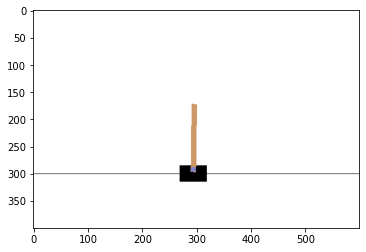

In [8]:
env_id = "CartPole-v1"
env = gym.make(env_id)
env.seed(0)
env.reset()
img = env.render("rgb_array")
env.close()
plt.imshow(img)

Now let's try interacting with the environment. All environments will first define an observation space and action space. These spaces define the shape and structure of the observations returned by the environment and the actions it accepts.

Neatly, the action space `env.action_space` allows you to randomly sample actions to try out. We will write a simple environment loop with random actions below. The loop will repeatedly ask for an action and we will step forward in the environment with that action via `env.step(action)`. 

You might notice that `env.step` returns 4 items, `obs`, `reward`, `done`, and `info`. `obs` is the next observation. `reward` is the scalard reward signal given. `done` represents a somewhat ambiguous meaning. When it's `True` it means the episode is completed and you must call `env.reset()` before stepping through it again. Episode completion can occur for a number of reasons depending on the chosen environment. For CartPole-v0, `done` is `True` whenever a time limit is reached or if the pole falls down too far. Finally `info` usually is not important, but may contain some useful information depending on the environment.

For users without a GUI, we also provide a simple animation function to record and save videos

In [9]:
def animate(imgs, video_name=None, _return=True):
    # using cv2 to generate videos
    import cv2
    import os
    import string
    import random
    video_name = video_name if video_name is not None else ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'VP80'), 20, (width,height))
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)

In [10]:
# The environment loop
obs = env.reset() # always reset before starting a new episode!
imgs = []
for i in range(100):
    action = env.action_space.sample() # sample a random action
    obs, reward, done, info = env.step(action) # get the new observation and reward
    imgs += [env.render("rgb_array")] # save to video
    if done: env.reset()
env.close() # close the display window and free up resources
animate(imgs, "random_interaction.webm") # generate the video replay

OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


## 2 Reinforcement Learning

Now that we know how an environment works, we can try to solve it via RL. The optimization code for an RL algorithm is out of the scope of the tutorial so we will rely on a popular RL library called [Stable Baselines 3 (SB3)](https://github.com/DLR-RM/stable-baselines3). Run the command below to install it

In [11]:
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 kB 798.1 kB/s eta 0:00:00a 0:00:01


### 2.1 RL Training
Training RL algorithms for single-agent environments like CartPole is simple with SB3.

The algorithm we will use is called PPO. While the specifics of the algorithm are out of the scope, the general way an RL algorithm like PPO works is via a two stage process that constantly repeats.

1. Collect interaction samples with sampled actions (observation, action, reward) from an environment and store into a replay buffer.

2. Sample from the replay buffer and optimize the policy to maximize the return

Below is some example code which trains a policy by interacting for up to 10,000 timesteps with the environment and then evaluates it. You will notice that compared to using random actions, this policy can keep the pole upright for much longer (success!)

In [12]:
from stable_baselines3 import PPO

env = gym.make("CartPole-v1")

# create a PPO algorithm powered agent
model = PPO("MlpPolicy", env, verbose=1)
# learn with a budget of 10,000 environment interactions
model.learn(total_timesteps=10_000)

# evaluate and watch the learned policy
obs = env.reset()
imgs = []
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    imgs += [env.render("rgb_array")] # save to video
    # VecEnv resets automatically
    if done:
        obs = env.reset()
env.close()
animate(imgs, "ppo_policy.webm") # generate the video replay

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 21       |
| time/              |          |
|    fps             | 1451     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.8        |
|    ep_rew_mean          | 26.8        |
| time/                   |             |
|    fps                  | 1040        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009446542 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss   

OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


### 2.2 Scaling up Deep RL

RL is often known for being a promising direction, but a fairly inefficient one. The particular algorithm used above is called PPO and has been a staple of the RL research community as it is generally easy to tune and very robust. However it is very **sample inefficient**, meaning it needs many many environment interactions in order to learn something. One way of dealing with this problem is to simply scale up the training by making it run faster. (Another way is to use different algorithms e.g. off-policy ones such as SAC but that's a topic beyond the scope of this tutorial)

A simple way to increase the speed at which we sample from an environment is to sample from many environments simultaneously. This enables us to leverage the power of parallel computation that is fast in neural networks and even faster when using a GPU/TPU. We can run `n_envs` environments simultaneously to form a single **Vectorized Environment**.

Vectorized environments **batch** an environment so that returned observations have an additional batch dimension (e.g. if it was shape `(3,)` it's new shape is `(B, 3)`) and accepted actions must also have this batch dimension, with `B` equal to the number of parallel environments. As vectorized environments accept a batch of actions, with GPUs/TPUs we can easily generate this batch of actions far faster than generating them one at a time, improving the speed at which we sample from an environment.

Try changing the `n_envs` parameter below. You will notice a massive speed up in the training time as `n_envs` is larger. Note that `n_envs` shouldn't be higher than the number of cores your CPU has.

In [13]:
from stable_baselines3.common.env_util import make_vec_env

n_envs = 2 # configure how many environments to run in parallel.

env = make_vec_env("CartPole-v1", n_envs=n_envs)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10_000)

obs = env.reset()
imgs = []
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    imgs += [env.render("rgb_array")] # save to video
    # VecEnv resets automatically so no need to do below
    # if done: env.reset()
env.close()
animate(imgs, "ppo_policy_vec_env.webm") # generate the video replay

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.6     |
|    ep_rew_mean     | 21.6     |
| time/              |          |
|    fps             | 2678     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.6        |
|    ep_rew_mean          | 28.6        |
| time/                   |             |
|    fps                  | 1508        |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.013709836 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | 0.000806    |
|    learning

OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


## 3 Final Thoughts

And that's the basics of programming a deep RL agent! Pick an environment, vectorize it, and run it through a RL library like SB3.

For more complicated environments like robotics or multi-agent environments there's a lot more work involved. This may include **reward shaping**, **hyperparameter tuning**, as well as 

[Part 2 of the tutorial series](https://www.kaggle.com/code/stonet2000/rl-with-lux-2-rl-problem-solving) will show RL and problem solving techniques to simplify the Lux AI Season 2 environment. By the end of part 2 you can automatically train a working agent with RL that's submittable to the competition.